<a href="https://colab.research.google.com/github/0xpix/CERI-Project/blob/main/notebooks/Geemap_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Earth Engine

In [2]:
# @title Connect to my private Repo
# Essentiel libraries
from google.colab import userdata
import subprocess
import os

repo_url = f"https://{userdata.get('GITHUB_KEY')}@github.com/0xpix/CERI-Project.git"
repo_dir = "/content/CERI"
main_dir = "/content"

def run_command(command):
    result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    print(result.stdout)
    if result.stderr:
        print(result.stderr)

# Check if the .git directory exists within the repo directory
if os.path.isdir(os.path.join(repo_dir, '.git')):
    print("\033[92m" + f"The repository '{repo_dir}' already exists. Fetching the latest changes..." + "\033[0m")
    # Cd to the directory CERI
    os.chdir(main_dir)
    # Fetch the latest changes
    os.system('git pull origin main')
    # Go back to the main folder
    os.chdir(repo_dir)
else:
    print("\033[92m" + f"Cloning the repository '{repo_dir}'..." + "\033[0m")
    # Clone the repo inside the directory CERI
    os.system(f'git clone {repo_url} {repo_dir}')
    # Cd to the directory CERI
    os.chdir(repo_dir)

Cloning the repository '/content/CERI'...


In [3]:
# @title Install Packages
%%capture
!pip install -U geemap # Upgrade geemap to the latest version
!pip install -q earthpy rioxarray cftime h5pyd Bottleneck # install in colab
!pip install rasterio localtileserver # for read HDF files

In [4]:
# @title Import Libraries
import warnings
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import earthpy as et
import random
import time
import os
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# Earth Engine API
import ee
import geemap
import folium

# GEE authentication
try:
    ee.Initialize(project='aims-ai2324-std-aness-9fl')
except:
    ee.Authenticate()
    ee.Initialize(project='aims-ai2324-std-aness-9fl')

warnings.simplefilter('ignore')

# My functions
from github_push import git_operations
from src.visualization.visualizing import *
from src.utils import *

# ================
#   Data Related
# ================
# Define the path to the shapefile asset
shapefile_PATH = 'data/shapefile/Africa_Shapefile/afr_g2014_2013_0.shp'
asset_PATH = 'projects/aims-ai2324-std-aness-9fl/assets/Africa_shapefile'

# Define the Disasters data path
Disasters_in_africa_2000_2018_processed_PATH = "data/processed/Disasters_in_africa_2000_2018_processed.csv"

# Specify a list of country names for which the data is to be filtered
country_names = [
    "Burundi", "Kenya", "Rwanda", "South Sudan",
    "United Republic of Tanzania", "Uganda", "Djibouti", "Eritrea",
    "Ethiopia", "Somalia"
]

# ================
# Configs related
# ================
africa_map_config = {
    "center": [0, 17],
    "width": "75%",
    "height": 900,
    "zoom": 3.5,
    "data_ctrl": False,
    "toolbar_ctrl": False,
    "draw_ctrl": False
}

In [5]:
geemap.__version__ # geemap version

'0.32.1'

In [6]:
# DON'T RUN EVERY TIME
# Commit the changes
# git_operations("Updated script")

# Climate Disasters Dataset. (EM-DAT + GDIS)

In [152]:
# @title Parameters
'''
Disaster type
Flood (768), Storm (111), Drought (83), Earthquake (23), Volcanic activity (3)
'''

# Define color for each disaster type
disaster_colors = {
    "Flood": "#80B1D3",
    "Storm": "#BEBADA",
    "Drought": "#FFFFB3",
    "Earthquake": "#8DD3C7",
    "Volcanic activity": "#FB8072",
    "Mass movement (dry) ": "#FFFFFF"
}

# Parameters for legend
legend_keys = list(disaster_colors.keys())
legend_colors = list(disaster_colors.values())

# Function to set color for each feature based on disaster type
def set_color(feature):
    key = feature.get('Disaster type')
    color = disaster_colors.get(key, "black")  # default to black if type not found
    return feature.set('color', color)

In [153]:
df = pd.read_csv(Disasters_in_africa_2000_2018_processed_PATH)
df

disasterno   Country              Location Disaster type        Date  \
0      1999-9388  Djibouti                Dikhil       Drought  2001-01-06   
1      1999-9388  Djibouti   Tadjourah provinces       Drought  2001-01-06   
2      1999-9388  Djibouti              Djibouti       Drought  2001-01-06   
3      1999-9388  Djibouti                 Obock       Drought  2001-01-06   
4      1999-9388  Djibouti            Ali Sabieh       Drought  2001-01-06   
...          ...       ...                   ...           ...         ...   
43370  2018-0479   Burundi               Gatumba         Flood  2018-04-05   
43371  2018-0479   Burundi               Vugizo          Flood  2018-04-05   
43372  2018-0479   Burundi               Gatumba         Flood  2018-04-05   
43373  2018-0479   Burundi               Vugizo          Flood  2018-04-05   
43374  2018-0479   Burundi               Gatumba         Flood  2018-04-05   

       Year  Total deaths  Latitude  Longitude  
0      2001          0.00     11.37      42.19  
1      2001          0.00     12.01      42.53  
2      2001          0.00     11.51      43.01  
3      2001          0.00     12.28      43.09  
4      2001          0.00     11.25      42.91  
...     ...           ...       ...        ...  
43370  2018          0.00     -3.31      29.24  
43371  2018          0.00     -4.15      29.68  
43372  2018          0.00     -3.31      29.24  
43373  2018          0.00     -4.15      29.68  
43374  2018          0.00     -3.31      29.24  

[43375 rows x 9 columns]

In [154]:
# Initialize the map
Map_africa = geemap.Map(**africa_map_config)

# Convert the csv file (After preprocessing) into an earth engine feature
collections = feature2ee(Disasters_in_africa_2000_2018_processed_PATH)

# Apply the color setting function to the feature collection
collections_colored = collections.map(set_color)

# Add layers for each disaster type
for disaster_type, color in disaster_colors.items():
    disaster_subset = collections_colored.filter(ee.Filter.eq('disaster_type', disaster_type))
    Map_africa.addLayer(disaster_subset, {'color': color}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')

# Add scale to the map
Map_africa.addLayerControl()

# Display the map
Map_africa

CSV file converted successfully.


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
# Aggregate the number of disasters by country
disasters_by_country = collections.aggregate_histogram('location')

# Print the aggregated results
len(disasters_by_country.getInfo())

2542

## Plot the total deaths for each country

In [ ]:
# Aggregate the number of disasters by country
disasters_by_country = collections.aggregate_histogram('country')

# Print the aggregated results
disasters_by_country.getInfo()

{'Algeria': 5820,
 'Angola': 1600,
 'Benin': 593,
 'Botswana': 384,
 'Burkina Faso': 848,
 'Burundi': 625,
 'Cameroon': 157,
 'Central African Republic': 158,
 'Chad': 805,
 'Comoros': 46,
 'Djibouti': 112,
 'Egypt': 160,
 'Eritrea': 23,
 'Ethiopia': 696,
 'Gabon': 52,
 'Gambia': 101,
 'Ghana': 862,
 'Guinea': 195,
 'Guinea-Bissau': 146,
 'Kenya': 4062,
 'Lesotho': 282,
 'Liberia': 37,
 'Libya': 4,
 'Madagascar': 3897,
 'Malawi': 2301,
 'Mali': 801,
 'Mauritania': 499,
 'Mauritius': 51,
 'Morocco': 378,
 'Mozambique': 4628,
 'Namibia': 355,
 'Niger': 1218,
 'Nigeria': 1701,
 'Rwanda': 392,
 'Senegal': 667,
 'Seychelles': 895,
 'Sierra Leone': 42,
 'Somalia': 1116,
 'South Africa': 807,
 'South Sudan': 215,
 'Sudan': 1113,
 'Togo': 131,
 'Tunisia': 190,
 'Uganda': 1380,
 'Zambia': 564,
 'Zimbabwe': 2266}

In [ ]:
# Define visualization parameters
vis_params_disasters_count = {
    'min': 0,
    'max': 110,  # Adjust the max value based on your data
    'palette': ['#e0ca85', '#d1a82b', '#855727', '#930404', '#450000'] # ['#bfbfbf', '#838383', '#1a1a1a', '#4d1414', '#b40d0d']
}

# Join the disaster counts with the countries dataset
def add_disaster_count(feature):
    country_name = feature.get('ADM0_NAME')
    disaster_count = ee.Number(disasters_by_country.get(country_name, 0))
    return feature.set('disaster_count', disaster_count)

# Specify the Area of study and plot it in EE map
african_countries = ee.FeatureCollection(asset_PATH) # create a feature collection that contains multiple countries
countries_with_counts = african_countries.map(add_disaster_count)

In [ ]:
# Create an image for visualization
disaster_count_image = countries_with_counts.reduceToImage(
    properties=['disaster_count'],
    reducer=ee.Reducer.first()
)

# Create an interactive map
Map_africa_deaths = geemap.Map(**africa_map_config)

# Add countries with disaster counts to the map
Map_africa_deaths.addLayer(disaster_count_image.visualize(**vis_params_disasters_count), {}, 'Disaster Counts')

# Add a color bar
Map_africa_deaths.add_colorbar(vis_params_disasters_count, label='Number of Disasters')

# Display the map
Map_africa_deaths

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Interpretation
Countries like Algeria (88), Kenya (68), and Mozambique (108) have experienced a high number of disasters.

Countries like Madagascar (57), Uganda (59), Nigeria (57), Niger (41), Malawi (52), Angola (53), Ethiopia (31), and Sudan (34) show a significant number of disasters.

The rest of the countries in West and Central Africa, as well as some parts of East Africa, show relatively lower numbers of disasters.

## Plot total Death for each country

In [ ]:
# Load the data
data = pd.read_csv(Disasters_in_africa_2000_2018_processed_PATH)

# Remove duplicate entries based on Country and Date
data = data.drop_duplicates(subset=['Country', 'Date'])

# Aggregate deaths by country
deaths_by_country = data.groupby('Country')['Total deaths'].sum().to_dict()
deaths_dict = ee.Dictionary(deaths_by_country)

In [ ]:
# Functions
def create_feature_collection():
    countries = ee.FeatureCollection(asset_PATH) # create a feature collection that contains multiple countries

    def add_death_count(feature):
        country_name = feature.get('ADM0_NAME')
        deaths = ee.Number(deaths_dict.get(country_name, 0))
        return feature.set('deaths', deaths)

    return countries.map(add_death_count)

feature_collection = create_feature_collection()

In [ ]:
# Parameters
vis_params_deaths = {
    'min': 0,
    'max': max(deaths_by_country.values()),
    'palette': ['#e0ca85', '#d1a82b', '#855727', '#930404', '#450000']
}

deaths_image = feature_collection.reduceToImage(
    properties=['deaths'],
    reducer=ee.Reducer.first()
)

In [ ]:
# Create an interactive map
Map_africa_deaths = geemap.Map(**africa_map_config)

# Add countries with disaster counts to the map
Map_africa_deaths.addLayer(deaths_image.visualize(**vis_params_deaths), {}, 'Deaths by Country')

# Add a color bar
Map_africa_deaths.add_colorbar(vis_params_deaths, label='Number of Deaths')

# Display the map
Map_africa_deaths

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Interpretation
Somalia has the highest number of deaths on the continent, in the range of 15,000 to 20,000.

Algeria has a noticeable number of deaths.

The rest of the African countries have lower numbers of deaths, with many countries having very few or zero deaths.

# Landscan Global using Google earth engine

## Continent level

In [ ]:
# @title Legend
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 200px; height: 300px;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color: rgba(255, 255, 255, 0.8);
            padding: 10px; color: #000000;">
    <h4 style="margin-top:0;color: #000000;">Population Count (Estimate)</h4>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #D3D3D3; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">No Data</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #FFFFCC; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">0 - 5</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #FFEDA0; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">6 - 25</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #FEB24C; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">26 - 50</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #FD8D3C; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">51 - 100</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #FC4E2A; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">101 - 500</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #E31A1C; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">501 - 2500</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #BD0026; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">2501 - 5000</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #800026; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">5001 - 185000</span>
    </div>
</div>
'''

In [ ]:
# @title Parameters
# Define the ImageCollection
landscan_global = ee.ImageCollection("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL") # Global
africa_shapefile = ee.FeatureCollection(asset_PATH)
landscan_africa = landscan_global.map(lambda image: image.clip(africa_shapefile)) # Africa only

# Define the SLD style for population count intervals
popcount_intervals = '''
<RasterSymbolizer>
  <ColorMap type="intervals" extended="false">
    <ColorMapEntry color="#CCCCCC" quantity="0" label="No Data"/>
    <ColorMapEntry color="#FFFFBE" quantity="5" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FEFF73" quantity="25" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FEFF2C" quantity="50" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FFAA27" quantity="100" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FF6625" quantity="500" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FF0023" quantity="2500" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#CC001A" quantity="5000" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#730009" quantity="185000" label="Population Count (Estimate)"/>
  </ColorMap>
</RasterSymbolizer>
'''

# Define the legend dictionary
legend_dict = {
    'No Data': '#CCCCCC',
    '0 - 5': '#FFFFBE',
    '6 - 25': '#FEFF73',
    '26 - 50': '#FEFF2C',
    '51 - 100': '#FFAA27',
    '101 - 500': '#FF6625',
    '501 - 2500': '#FF0023',
    '2501 - 5000': '#CC001A',
    '5001 - 185000': '#730009'
}

In [ ]:
# Get the first image from the ImageCollection
landscan_2000 = landscan_africa.first()

# Create a map
Map = geemap.Map(**africa_map_config)

# Add layers to the map
Map.add_layer(
    landscan_2000.sldStyle(popcount_intervals), {}, 'Population Count Estimate 2000'
)

# Add the legend to the map
Map.add_html(legend_html, position='bottomleft')

# Display the map
Map_africa.addLayerControl()
Map

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [ ]:
# Get the first image from the collection for the year 2000
image_2000 = ee.Image("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-2000")
image_2000 = image_2000.toFloat() # Convert the image to a float type to ensure proper calculations

# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)
roi = africa_shapefile.geometry().dissolve() # Define the region of interest (ROI) for Africa using the shapefile

# Define the intervals
intervals = [
    (0, 5), (5, 25), (25, 50), (50, 100),
    (100, 500), (500, 2500), (2500, 5000), (5000, 185000)
]

In [ ]:
# Compute mean, min, max, stdDev, and percentiles
mean_dict = image_2000.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
min_max_dict = image_2000.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
std_dev_dict = image_2000.reduceRegion(
    reducer=ee.Reducer.stdDev(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
percentiles_dict = image_2000.reduceRegion(
    reducer=ee.Reducer.percentile([10, 25, 50, 75, 90]),
    geometry=roi,
    scale=1000,
    bestEffort=True
)

# Calculate sum, mean, min, max, and stdDev of the population
sum_population = image_2000.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
mean_population = image_2000.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
min_max_population = image_2000.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
std_dev_population = image_2000.reduceRegion(
    reducer=ee.Reducer.stdDev(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)

# Combine results into a summary dictionary
summary = {
    'Mean Population': mean_dict.getInfo(),
    'Min Population': min_max_dict.getInfo()['min'],
    'Max Population': min_max_dict.getInfo()['max'],
    'Standard Deviation of Population': std_dev_dict.getInfo(),
    'Population Percentiles': percentiles_dict.getInfo(),
    'Total Population': sum_population.getInfo()['sum'],
    'Mean Population': mean_population.getInfo()['mean'],
    'Min Population': min_max_population.getInfo()['min'],
    'Max Population': min_max_population.getInfo()['max'],
    'Standard Deviation of Population': std_dev_population.getInfo()
}

# Print the summary
print('Statistical Summary:', summary)

In [ ]:
# Function to create a grid of smaller regions
def create_grid(geometry, rows, cols):
    bounds = geometry.bounds().coordinates().get(0).getInfo()
    lon_min, lat_min = bounds[0]
    lon_max, lat_max = bounds[2]

    lon_step = (lon_max - lon_min) / cols
    lat_step = (lat_max - lat_min) / rows

    grid_cells = []
    for i in range(cols):
        for j in range(rows):
            cell = ee.Geometry.Rectangle([
                [lon_min + i * lon_step, lat_min + j * lat_step],
                [lon_min + (i + 1) * lon_step, lat_min + (j + 1) * lat_step]
            ])
            grid_cells.append(cell)

    return grid_cells

# Split the region into smaller grids
grid_cells = create_grid(roi, 10, 10)  # Adjust the grid size as needed

# Function to calculate the total population for a given year and grid cell
def calculate_population(image, region, scale):
    total_population = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=scale,
        maxPixels=1e12
    ).get('b1').getInfo()
    return total_population

# Initialize a DataFrame to store the results
years = list(range(2000, 2019))
population_data = []

# Calculate the population for each year and each grid cell, then aggregate the results
for year in years:
    image = landscan_global.filter(ee.Filter.eq('system:index', f'landscan-global-{year}')).first()
    if image is None:
        continue

    year_total_population = 0
    for cell in grid_cells:
        population = calculate_population(image, cell, 1000) # scale = 1000 to get more accurate results
        year_total_population += population if population is not None else 0

    population_data.append({
        'Year': year,
        'Population': year_total_population
    })

In [ ]:
# Convert the data into a pandas DataFrame
df_population = pd.DataFrame(population_data)

# Set the display format for floating-point numbers to avoid scientific notation
pd.options.display.float_format = '{:,.2f}'.format

# Print the DataFrame
print(df_population)

In [ ]:
# Check point (saved dataframe for population count over the years)
AFRICA_POP_PATH = "/content/CERI/data/processed/Africa_level_population_2000_2018.csv"

# Save the file
# df_population_africa.to_csv(AFRICA_POP_PATH, index=False)

# Load the file
df_population_africa = pd.read_csv(AFRICA_POP_PATH)
pd.options.display.float_format = '{:,.2f}'.format
df_population_africa

Unnamed: 0  Year       Population
0            0  2000   859,820,075.30
1            1  2001   878,720,050.80
2            2  2002   896,187,284.80
3            3  2003   916,226,740.10
4            4  2004   930,725,786.30
5            5  2005   952,241,238.50
6            6  2006   973,253,782.00
7            7  2007   994,688,717.90
8            8  2008 1,031,934,403.00
9            9  2009 1,051,343,733.00
10          10  2010 1,082,025,676.00
11          11  2011 1,118,577,134.00
12          12  2012 1,137,994,035.00
13          13  2013 1,165,388,802.00
14          14  2014 1,206,209,040.00
15          15  2015 1,237,959,443.00
16          16  2016 1,264,643,040.00
17          17  2017 1,291,548,155.00
18          18  2018 1,341,748,432.00

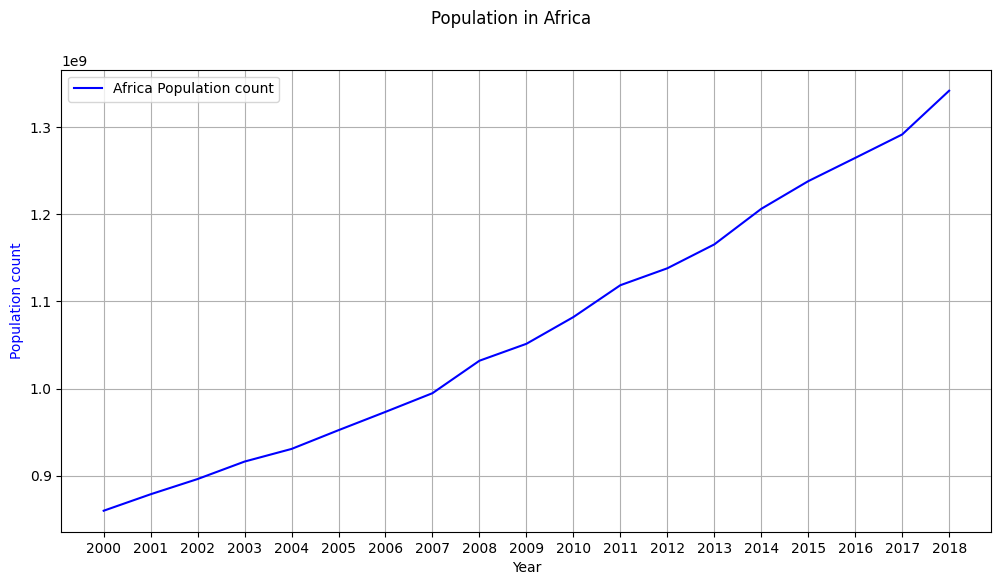

In [ ]:
# Plot the population changes and disaster counts for the specified country
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_population_africa['Year'].astype(str), df_population_africa['Population'], label=f"Africa Population count", color='b')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population count', color='b')

# Title and legend
fig.suptitle(f'Population in Africa')
ax1.legend(loc='upper left')

# Grid and show
ax1.grid(True)
plt.show()

## Country level

In [163]:
# @title Parameters
# Define the ImageCollection
landscan_global = ee.ImageCollection("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL")

# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)

# List of countries to filter
countries = [
    "Zimbabwe", "Mozambique", "Sudan", "Malawi", "Ethiopia", "Mauritania",
    "Mali", "Algeria", "Uganda", "Madagascar", "Kenya", "Senegal", "Angola",
    "South Africa", "Somalia", "Comoros", "Burundi", "Niger", "Burkina Faso",
    "Ghana", "Rwanda", "South Sudan", "Namibia", "Chad", "Zambia", "Nigeria",
    "Benin", "Egypt", "Botswana"
]

# Filter the Africa shapefile to include only the specified countries
filtered_countries = africa_shapefile.filter(ee.Filter.inList('ADM0_NAME', countries))

# Define the intervals
intervals = [
    (0, 5), (5, 25), (25, 50), (50, 100),
    (100, 500), (500, 2500), (2500, 5000), (5000, 185000)
]

In [ ]:
country_name = "Zimbabwe"
filtered_country = africa_shapefile.filter(ee.Filter.eq('ADM0_NAME', country_name))

# Create a map
Map = geemap.Map(height=800, width="70%")

pop_2000 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-2000")
pop_2010 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-2010")
clipped_image_2000 = pop_2000.clip(filtered_country) # Clip the landscan_global image with the country's boundary
clipped_image_2010 = pop_2010.clip(filtered_country)

left_layer = geemap.ee_tile_layer(clipped_image_2000.sldStyle(popcount_intervals), {}, "Pop count 2000")
right_layer = geemap.ee_tile_layer(clipped_image_2010.sldStyle(popcount_intervals), {}, "Pop count 2010")

# Map.add_layer(clipped_image.sldStyle(popcount_intervals), {}, 'Population Count Estimate 2000')
Map.add_layer(filtered_country.style(**{'color': 'red'}), {}, country_name)

# Add the legend to the map
Map.add_legend(title='Population Count Estimate', legend_dict=legend_dict)

# Center the map on the selected country
country_geom = filtered_country.geometry()
Map.centerObject(country_geom, zoom=7)

# Display the map
Map.split_map(left_layer, right_layer)
Map

Map(center=[-18.99298187251295, 29.868341570404244], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [ ]:
# Function to calculate the total population for a given year and region
def calculate_population(image, region, scale):
    total_population = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region.geometry(),
        scale=scale,
        maxPixels=1e12
    ).get('b1').getInfo()
    return total_population

# Initialize a DataFrame to store the results
years = list(range(2000, 2019))
population_data = []

# Calculate the population for each country and each year, then store the results
for country in countries:
    country_feature = filtered_countries.filter(ee.Filter.eq('ADM0_NAME', country)).first()
    if country_feature is None:
        continue

    for year in years:
        image = landscan_global.filter(ee.Filter.eq('system:index', f'landscan-global-{year}')).first()
        if image is None:
            continue

        population = calculate_population(image, country_feature, 1000)
        population_data.append({
            'Country': country,
            'Year': year,
            'Population': population if population is not None else 0
        })

In [ ]:
# Convert the data into a pandas DataFrame
df_population_country_lvl = pd.DataFrame(population_data)

# Set the display format for floating-point numbers to avoid scientific notation
pd.options.display.float_format = '{:,.2f}'.format

# Print the DataFrame
print(df_population_country_lvl)

In [148]:
# Check point
Country_LVL_POP_PATH = "/content/CERI/data/processed/Country_level_population_2000_2018.csv"

# Save the file
# df_population_country_lvl.to_csv(Country_LVL_POP_PATH, index=False)

# Load the file
df_population_country_lvl = pd.read_csv(Country_LVL_POP_PATH)
pd.options.display.float_format = '{:,.2f}'.format
df_population_country_lvl.head(3)

Country  Year    Population
0  Zimbabwe  2000  9,751,919.54
1  Zimbabwe  2001  9,707,988.09
2  Zimbabwe  2002 10,646,151.27

## Change detection


In [149]:
# @title Choose the year
year_1 = 2007 # @param {"type": "number"}
year_2 = 2009 # @param {"type": "number"}

In [150]:
# @title Parameters
single_country_map_config = {
    'height':800,
    'width':"70%",
    'center': [0, 20],
    'zoom': 3
}

# Add population change layer to the map
vis_params = {
    'min': -3,
    'max': 3,
    'palette': ['#eb389f', '#cccccc', '#018f1d']
}

# Add a legend to the map
legend_dict = {
    'Decline': '#eb389f',
    'Uninhabited': '#cccccc',
    'Growth': '#018f1d'
}

# Define the legend
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 200px; height: 100px;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color: rgba(255, 255, 255, 0.8);
            padding: 10px; color: #000000">
    <h4 style="margin-top:0; color: #000000">Population Change</h4>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #eb389f; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">Decline</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #cccccc; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">Uninhabited</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #018f1d; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">Growth</span>
    </div>
</div>
'''

In [151]:
df_population_country_lvl['Country'].unique()

array(['Zimbabwe', 'Mozambique', 'Sudan', 'Malawi', 'Ethiopia',
       'Mauritania', 'Mali', 'Algeria', 'Uganda', 'Madagascar', 'Kenya',
       'Senegal', 'Angola', 'South Africa', 'Somalia', 'Comoros',
       'Burundi', 'Niger', 'Burkina Faso', 'Ghana', 'Rwanda',
       'South Sudan', 'Namibia', 'Chad', 'Zambia', 'Nigeria', 'Benin',
       'Egypt', 'Botswana'], dtype=object)

### Calculate the change detection

In [ ]:
africa_shapefile = ee.FeatureCollection(asset_PATH)

# Function to filter a country from the shapefile
def filter_country(country_name):
    return africa_shapefile.filter(ee.Filter.eq('ADM0_NAME', country_name))

# Function to calculate population change between two years for a given country
def calculate_population_change(country_name, year1, year2):
    # Load population data for the specified years
    img1 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year1}")
    img2 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year2}")

    # Calculate the change
    pop_change = img2.subtract(img1)

    # Filter the country based on input
    filtered_country = filter_country(country_name)

    # Clip the change image to the country region
    pop_change_clipped = pop_change.clip(filtered_country)

    # Calculate the total change in population
    scale = 1000  # Scale in meters
    total_change = pop_change_clipped.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=filtered_country.geometry(),
        scale=scale,
        maxPixels=1e9
    )

    # Get the change value
    change_dict = total_change.getInfo()

    # Extract only the numeric values
    change_value = change_dict.get('b1', 0)

    return change_value

# List of countries to process
countries = ['Zimbabwe', 'Mozambique', 'Sudan', 'Malawi', 'Ethiopia', 'Mauritania', 'Mali', 'Algeria', 'Uganda',
             'Madagascar', 'Kenya', 'Senegal', 'Angola', 'South Africa', 'Somalia', 'Comoros', 'Burundi', 'Niger',
             'Burkina Faso', 'Ghana', 'Rwanda', 'South Sudan', 'Namibia', 'Chad', 'Zambia', 'Nigeria', 'Benin',
             'Egypt', 'Botswana']
year_1 = 2007
year_2 = 2009

# Calculate population changes for all specified countries
pop_changes = {}
for country in countries:
    pop_change_value = calculate_population_change(country, year_1, year_2)
    pop_changes[country] = pop_change_value

# Print the results
for country, change in pop_changes.items():
    print(f"Population change in {country} from {year_1} to {year_2}: {change}")

Population change in Zimbabwe from 2007 to 2009: -786071.2549019628
Population change in Mozambique from 2007 to 2009: 707018.635294119
Population change in Sudan from 2007 to 2009: 1192704.3137254892
Population change in Malawi from 2007 to 2009: 1235505.2980392126
Population change in Ethiopia from 2007 to 2009: 7519627.8313725395
Population change in Mauritania from 2007 to 2009: -127205.64705882341
Population change in Mali from 2007 to 2009: 1235764.666666668
Population change in Algeria from 2007 to 2009: 711417.9803921569
Population change in Uganda from 2007 to 2009: 1870770.3019607838
Population change in Madagascar from 2007 to 2009: 1018827.3686274518
Population change in Kenya from 2007 to 2009: 1842491.3450980398
Population change in Senegal from 2007 to 2009: 1016368.5686274485
Population change in Angola from 2007 to 2009: 459830.50196078414
Population change in South Africa from 2007 to 2009: 4330337.517647049
Population change in Somalia from 2007 to 2009: 600046.21568

### Visualization

#### Visualization without disasters

In [ ]:
vis_changde_detection = {
    'zoom': 6,
    'width': '60%',
    'height': 800
}

In [ ]:
# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)

# List of countries to filter
countries_list = [
    "Zimbabwe", "Mozambique", "Sudan", "Malawi", "Ethiopia", "Mauritania",
    "Mali", "Algeria", "Uganda", "Madagascar", "Kenya", "Senegal", "Angola",
    "South Africa", "Somalia", "Comoros", "Burundi", "Niger", "Burkina Faso",
    "Ghana", "Rwanda", "South Sudan", "Namibia", "Chad", "Zambia", "Nigeria",
    "Benin", "Egypt", "Botswana"
]

# Function to filter countries
def filter_countries(country_names):
    return africa_shapefile.filter(ee.Filter.inList('ADM0_NAME', country_names))

# Function to calculate population change between two years for a given country or list of countries
def calculate_population_change(country_names, year1, year2):
    # Load population data for the specified years
    img1 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year1}")
    img2 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year2}")

    # Calculate the change
    pop_change = img2.subtract(img1)

    # Filter countries based on input
    filtered_countries = filter_countries(country_names)

    # Clip the change image to the country region
    pop_change_clipped = pop_change.clip(filtered_countries)

    return pop_change_clipped

# Example usage
single_country_name = ['Zimbabwe']
year1 = 2007
year2 = 2009
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Create a geemap map
Map = geemap.Map(**vis_changde_detection)

Map.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')

# Add country boundaries
Map.addLayer(filter_countries(single_country_name), {'opacity': 0.4}, 'Country Boundary')

# Display the map
Map

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
# Example usage
single_country_name = ['Ghana']
year1 = 2007
year2 = 2009
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Create a geemap map
Map = geemap.Map(center=[0, 20], zoom=3)

Map.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')

# Add country boundaries
Map.addLayer(filter_countries(single_country_name), {'opacity': 0.4}, 'Country Boundary')

# Display the map
Map

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
# Example usage
single_country_name = ['Burundi']
year1 = 2007
year2 = 2009
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Create a geemap map
Map = geemap.Map(center=[0, 20], zoom=3)

Map.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')

# Add country boundaries
Map.addLayer(filter_countries(single_country_name), {'opacity': 0.4}, 'Country Boundary')

# Display the map
Map

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

#### Visualization with disasters

In [ ]:
# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)

# List of countries to filter
countries_list = [
    "Zimbabwe", "Mozambique", "Sudan", "Malawi", "Ethiopia", "Mauritania",
    "Mali", "Algeria", "Uganda", "Madagascar", "Kenya", "Senegal", "Angola",
    "South Africa", "Somalia", "Comoros", "Burundi", "Niger", "Burkina Faso",
    "Ghana", "Rwanda", "South Sudan", "Namibia", "Chad", "Zambia", "Nigeria",
    "Benin", "Egypt", "Botswana"
]

# Define color for each disaster type
disaster_colors = {
    "Flood": "#80B1D3",
    "Storm": "#BEBADA",
    "Drought": "#FFFFB3",
    "Earthquake": "#8DD3C7",
    "Volcanic activity": "#FB8072",
}

# Parameters for legend
legend_keys = list(disaster_colors.keys())
legend_colors = list(disaster_colors.values())

# Create a geemap map
viz_dis_map_config = {
    'center': [0, 20],
    'zoom': 3
}

# Add population change layer to the map
vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'white', 'green']
}

In [ ]:
# Function to generate a list of dates
def generate_date_list(start_date, end_date):
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return date_list

# Generate a list of dates for the year 2008
date_list = generate_date_list(datetime(2008, 1, 1), datetime(2008, 12, 31))

# Function to filter countries
def filter_countries(country_names):
    return africa_shapefile.filter(ee.Filter.inList('ADM0_NAME', country_names))

# Function to calculate population change between two years for a given country or list of countries
def calculate_population_change(country_names, year1, year2):
    # Load population data for the specified years
    img1 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year1}")
    img2 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year2}")

    # Calculate the change
    pop_change = img2.subtract(img1)

    # Filter countries based on input
    filtered_countries = filter_countries(country_names)

    # Clip the change image to the country region
    pop_change_clipped = pop_change.clip(filtered_countries)

    return pop_change_clipped

# Function to set color for each feature based on disaster type
def set_color(feature):
    key = feature.get('disaster_type')
    color = disaster_colors.get(key, "black")  # default to black if type not found
    return feature.set('color', color)

In [ ]:
# it has 32 climate disaster = Drought in 2008
single_country_name = ['Burundi']
year1 = 2008
year2 = 2013

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Disaster type: Flood, Count: 1
Disaster type: Storm, Count: 0
Disaster type: Drought, Count: 36
Disaster type: Earthquake, Count: 0
Disaster type: Volcanic activity, Count: 0


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
single_country_name = ['Ghana']
year1 = 2007
year2 = 2009

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Disaster type: Flood, Count: 4
Disaster type: Storm, Count: 0
Disaster type: Drought, Count: 0
Disaster type: Earthquake, Count: 0
Disaster type: Volcanic activity, Count: 0


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

Ghana - flood - 2018 - 14000 people displaced

In [ ]:
# Generate a list of dates for the year 2009
date_list = generate_date_list(datetime(2009, 1, 1), datetime(2009, 12, 31))

single_country_name = ['Ghana']
year1 = 2008
year2 = 2010

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Disaster type: Flood, Count: 66
Disaster type: Storm, Count: 0
Disaster type: Drought, Count: 0
Disaster type: Earthquake, Count: 0
Disaster type: Volcanic activity, Count: 0


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

Ghana - flood - 2009 -

In [ ]:
# Generate a list of dates for the year 2009
date_list = generate_date_list(datetime(2012, 1, 1), datetime(2012, 12, 31))

single_country_name = ['Nigeria']
year1 = 2011
year2 = 2013

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Disaster type: Flood, Count: 342
Disaster type: Storm, Count: 0
Disaster type: Drought, Count: 0
Disaster type: Earthquake, Count: 0
Disaster type: Volcanic activity, Count: 0


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

Nigeria - flood - 3871000 displaced people

In [ ]:
'''
       Country  Internal Displacements       Date Disaster type
0      Nigeria                 8531816 2009-01-01         Flood
1      Somalia                 4643944 2008-03-11         Flood
2     Ethiopia                 3675840 2008-05-30         Flood
3  South Sudan                 2503376 2012-01-01         Flood
4        Niger                 2114305 2008-07-01         Flood
5        Sudan                 1955348 2008-08-01         Flood
6        Kenya                 1742910 2008-03-17         Flood
7   Mozambique                 1498829 2008-01-09      Wildfire
8   Madagascar                 1430408 2008-01-27         Storm
9       Malawi                  987083 2009-01-01    Earthquake
'''

In [ ]:
# @title Ethiopia
# Ethiopia                 3675840 2008-05-30         Flood
# Generate a list of dates for the year 2008
year = 2008
date_list = generate_date_list(datetime(year, 1, 1), datetime(year, 12, 31))

single_country_name = ['Ethiopia']
year1 = year - 1
year2 = year + 1

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Disaster type: Flood, Count: 0
Disaster type: Storm, Count: 0
Disaster type: Drought, Count: 36
Disaster type: Earthquake, Count: 0
Disaster type: Volcanic activity, Count: 0


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
# @title Ethiopia
# Ethiopia                 3675840 2008-05-30         Flood
# Generate a list of dates for the year 2008
year = 2008
date_list = generate_date_list(datetime(year, 1, 1), datetime(year, 12, 31))

single_country_name = ['Ethiopia']
year1 = year
year2 = year + 5

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
# @title South Sudan
# South Sudan                 2503376 2012-01-01         Flood
# Generate a list of dates for the year 2012
year = 2012
date_list = generate_date_list(datetime(year, 1, 1), datetime(year, 12, 31))

single_country_name = ['South Sudan']
year1 = year - 1
year2 = year + 1

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Disaster type: Flood, Count: 26
Disaster type: Storm, Count: 0
Disaster type: Drought, Count: 0
Disaster type: Earthquake, Count: 0
Disaster type: Volcanic activity, Count: 0


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
# @title South Niger
# Niger                 2114305 2008-07-01         Flood
# Generate a list of dates for the year 2008
year = 2008
date_list = generate_date_list(datetime(year, 1, 1), datetime(year, 12, 31))

single_country_name = ['Niger']
year1 = year - 1
year2 = year + 1

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Disaster type: Flood, Count: 16
Disaster type: Storm, Count: 0
Disaster type: Drought, Count: 0
Disaster type: Earthquake, Count: 0
Disaster type: Volcanic activity, Count: 0


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

# Land use Land cover GLC


Google earth LULC:
https://gee-community-catalog.org/projects/glc_fcs/

In [1]:
# @title parameters
# Define the class names, color palette and class values
class_names = [
    "Nothing",
    "Cropland rainfed",
    "Cropland rainfed",
    "Cropland rainfed",
    "Cropland irrigated or post-flooding",
    "Mosaic cropland (>50%) / natural vegetation (<50%)",
    "Mosaic natural vegetation (>50%) / cropland (<50%)",
    "Tree cover broadleaved evergreen (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover mixed leaf type (broadleaved and needleleaved)",
    "Mosaic tree and shrub (>50%) / herbaceous cover (<50%)",
    "Mosaic herbaceous cover (>50%) / tree and shrub (<50%)",
    "Shrubland",
    "Shrubland",
    "Shrubland",
    "Grassland",
    "Lichens and mosses",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Tree cover flooded fresh/brackish water",
    "Tree cover flooded saline water",
    "Shrub or herbaceous cover flooded",
    "Urban areas",
    "Bare areas",
    "Bare areas",
    "Bare areas",
    "Water bodies",
    "Permanent snow and ice"
]

color_palette = [
    '#ffffff','#ffff64', '#ffff64', '#ffff00', '#aaf0f0', '#dcf064', '#c8c864', '#006400',
    '#00a000', '#00a000', '#aac800', '#003c00', '#003c00', '#005000', '#285000','#285000',
    '#286400', '#788200', '#8ca000', '#be9600', '#966400', '#966400', '#966400', '#ffb432',
    '#ffdcd2', '#ffebaf', '#ffc864', '#ffd278', '#ffebaf', '#00785a', '#009678', '#00dc82',
    '#c31400', '#fff5d7', '#dcdcdc', '#fff5d7', '#0046c8', '#ffffff'
]

class_values = [
    0, 10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90,
    100, 110, 120, 121, 122, 130, 140, 150, 151, 152, 153, 160, 170, 180, 190,
    200, 201, 202, 210, 220
]

# Ensure the number of colors matches the number of class values
assert len(color_palette) == len(class_values), "The number of colors must match the number of class values"
assert len(class_names) == len(class_values), "The number of class names must match the number of class values"

In [93]:
# Define the color palette
palette = [
    "#ffff64", "#ffff64", "#ffff00", "#aaf0f0", "#4c7300", "#006400", "#a8c800", "#00a000",
    "#005000", "#003c00", "#286400", "#285000", "#a0b432", "#788200", "#966400", "#964b00",
    "#966400", "#ffb432", "#ffdcd2", "#ffebaf", "#ffd278", "#ffebaf", "#00a884", "#73ffdf",
    "#9ebb3b", "#828282", "#f57ab6", "#66cdab", "#444f89", "#c31400", "#fff5d7", "#dcdcdc",
    "#fff5d7", "#0046c8", "#ffffff", "#ffffff"
]

class_names = [
    "Rainfed cropland", "Herbaceous cover cropland", "Tree or shrub cover (Orchard) cropland",
    "Irrigated cropland", "Open evergreen broadleaved forest", "Closed evergreen broadleaved forest",
    "Open deciduous broadleaved forest (0.15<fc<0.4)", "Closed deciduous broadleaved forest (fc>0.4)",
    "Open evergreen needle-leaved forest (0.15< fc <0.4)", "Closed evergreen needle-leaved forest (fc >0.4)",
    "Open deciduous needle-leaved forest (0.15< fc <0.4)", "Closed deciduous needle-leaved forest (fc >0.4)",
    "Open mixed leaf forest (broadleaved and needle-leaved)", "Closed mixed leaf forest (broadleaved and needle-leaved)",
    "Shrubland", "Evergreen shrubland", "Deciduous shrubland", "Grassland", "Lichens and mosses",
    "Sparse vegetation (fc<0.15)", "Sparse shrubland (fc<0.15)", "Sparse herbaceous (fc<0.15)", "Swamp",
    "Marsh", "Flooded flat", "Saline", "Mangrove", "Salt marsh", "Tidal flat", "Impervious surfaces",
    "Bare areas", "Consolidated bare areas", "Unconsolidated bare areas", "Water body", "Permanent ice and snow",
    "Filled value"
]

classes = [10, 11, 12, 20, 51, 52, 61, 62, 71, 72, 81, 82, 91, 92, 120, 121, 122,
               130, 140, 150, 152, 153, 181, 182, 183, 184, 185, 186, 187, 190, 200,
               201, 202, 210, 220, 0]

# Create a dictionary mapping class names to their colors
class_value_dict = dict(zip(class_names, class_values))

In [90]:
# Function to recode class values into sequential values starting from 1 onwards
def recode_classes(image):
    reclassed = image.remap(classes, ee.List.sequence(1, len(classes)))
    return reclassed

# Path to the Africa shapefile asset
africa_shapefile = ee.FeatureCollection(asset_PATH)

# Create a geemap map
Map = geemap.Map(**africa_map_config)

annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual")

# Load the GLC-FCS30D collection
image = annual.mosaic().clip(africa_shapefile)

# Iterate over each band (year) in the image
for i in range(1, 2):
    year = 2007 + i  # starts at year 2000 for annual maps
    layer_name = f"GLC FCS {year}"
    band = image.select(f"b{i}")

    # Apply the function to the band and add layer
    Map.addLayer(recode_classes(band), {'palette': palette}, layer_name)

# Add a layer control
Map.addLayerControl()

# Create a legend
legend_dict = dict(zip(class_names, palette))
Map.add_legend(title="Land Cover Classes", legend_dict=legend_dict)

# Display the map
Map

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

## plot any class

In [112]:
# Function to extract urban areas
def extract_urban(image):
    urban = image.eq(class_value)
    return urban.updateMask(urban)

# Path to the Africa shapefile asset
year = 2000
target_class = ["Impervious surfaces", "Water body"]
geometry = ee.FeatureCollection(asset_PATH) # Africa shapefile

# Load the GLC_FCS30D annual dataset
annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual")
Map = geemap.Map(**africa_map_config)

for class_name in target_class:
    class_index = class_names.index(class_name)
    class_value = classes[class_index]

    # Define the visualization parameters
    vis_params = {
        'min': 0,
        'max': 1,
        'palette': ['000000', palette[class_index]]
    }

    target_area = annual.map(extract_urban)
    target_area_2000 = target_area.select(f'b{year - 1999}')

    # Add the urban areas to the map
    Map.add_layer(target_area_2000.mosaic().clip(geometry), vis_params, class_name)

# Display the map
Map.addLayerControl()
Map

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

## Change detection

### Before and After plot

In [140]:
# Path to the Africa shapefile asset
disaster_year = 2009
year1 = disaster_year - 1
year2 = disaster_year + 1
target_class = ["Impervious surfaces", "Water body"]
geometry = ee.FeatureCollection(asset_PATH) # Africa shapefile

# Load the GLC_FCS30D annual dataset
annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual").mosaic()
annual_before = annual.select(f'b{year1 - 1999}')
annual_after = annual.select(f'b{year2 - 1999}')

Map = geemap.Map(**africa_map_config)

for class_name in target_class:
    class_index = class_names.index(class_name)
    class_value = classes[class_index]

    # Define the visualization parameters
    vis_params = {
        'min': 0,
        'max': 1,
        'palette': ['000000', palette[class_index]]
    }

    classified_area_before = annual_before.eq(class_value)
    classified_area_before_masked = classified_area_before.updateMask(classified_area_before)
    classified_area_after = annual_after.eq(class_value)
    classified_area_after_masked = classified_area_after.updateMask(classified_area_after)

    # Add the urban areas to the map
    Map.add_layer(classified_area_before_masked, vis_params, f"{class_name} Before")
    Map.add_layer(classified_area_after_masked, vis_params, f"{class_name} After")

# Display the map
Map.addLayerControl()
Map

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

### Change detection

In [147]:
# Path to the Africa shapefile asset
disaster_year = 2009
year1 = disaster_year - 1
year2 = disaster_year + 1
target_class = ["Impervious surfaces", "Water body"]
geometry = ee.FeatureCollection(asset_PATH) # Africa shapefile

# Load the GLC_FCS30D annual dataset
annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual")
annual_before = annual.mosaic().select(f'b{year1 - 1999}')
annual_after = annual.mosaic().select(f'b{year2 - 1999}')

Map = geemap.Map(**africa_map_config)

for class_name in target_class:
    class_index = class_names.index(class_name)
    class_value = classes[class_index]

    # Define the visualization parameters
    vis_params = {
        'min': 0,
        'max': 1,
        'palette': ['000000', palette[class_index]]
    }

    change_vis_params = {
        'min': -1,
        'max': 1,
        'palette': ['red', 'green']
    }

    classified_area_before = annual_before.eq(class_value)
    classified_area_before_masked = classified_area_before.updateMask(classified_area_before)
    classified_area_after = annual_after.eq(class_value)
    classified_area_after_masked = classified_area_after.updateMask(classified_area_after)

    # Calculate the change: 1 for gain, -1 for loss, 0 for no change.
    change = classified_area_after.subtract(classified_area_before)

    # Mask the change to only show areas where change occurred.
    change_masked = change.updateMask(change.neq(0))

    # Add the urban areas to the map
    Map.add_layer(classified_area_before_masked, vis_params, f"{class_name} Before")
    Map.add_layer(classified_area_after_masked, vis_params, f"{class_name} After")
    Map.add_layer(change_masked, change_vis_params, f"{class_name} change")

# Display the map
Map.addLayerControl()
Map

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

# Global Analysis

## Parameters

In [157]:
# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)

# List of countries to filter
countries_list = [
    "Zimbabwe", "Mozambique", "Sudan", "Malawi", "Ethiopia", "Mauritania",
    "Mali", "Algeria", "Uganda", "Madagascar", "Kenya", "Senegal", "Angola",
    "South Africa", "Somalia", "Comoros", "Burundi", "Niger", "Burkina Faso",
    "Ghana", "Rwanda", "South Sudan", "Namibia", "Chad", "Zambia", "Nigeria",
    "Benin", "Egypt", "Botswana"
]

# Define color for each disaster type
disaster_colors = {
    "Flood": "#80B1D3",
    "Storm": "#BEBADA",
    "Drought": "#FFFFB3",
    "Earthquake": "#8DD3C7",
    "Volcanic activity": "#FB8072",
}

# Parameters for legend
legend_keys = list(disaster_colors.keys())
legend_colors = list(disaster_colors.values())

# Create a geemap map
viz_dis_map_config = {
    'center': [0, 20],
    'zoom': 3
}

# Add population change layer to the map
vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'white', 'green']
}

In [158]:
# @title Functions
# Function to generate a list of dates
def generate_date_list(start_date, end_date):
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return date_list

# Generate a list of dates for the year 2008
date_list = generate_date_list(datetime(2008, 1, 1), datetime(2008, 12, 31))

# Function to filter countries
def filter_countries(country_names):
    return africa_shapefile.filter(ee.Filter.inList('ADM0_NAME', country_names))

# Function to calculate population change between two years for a given country or list of countries
def calculate_population_change(country_names, year1, year2):
    # Load population data for the specified years
    img1 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year1}")
    img2 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year2}")

    # Calculate the change
    pop_change = img2.subtract(img1)

    # Filter countries based on input
    filtered_countries = filter_countries(country_names)

    # Clip the change image to the country region
    pop_change_clipped = pop_change.clip(filtered_countries)

    return pop_change_clipped

# Function to set color for each feature based on disaster type
def set_color(feature):
    key = feature.get('disaster_type')
    color = disaster_colors.get(key, "black")  # default to black if type not found
    return feature.set('color', color)

In [ ]:
# Function to generate a list of dates
def generate_date_list(start_date, end_date):
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return date_list

## Study case 1: Niger (south)

In [165]:
def create_disaster_map(country_name, disaster_year):
    # Create the map
    Map_africa = geemap.Map(**viz_dis_map_config)
    year_before = disaster_year - 1
    year_after  = disaster_year + 1

    date_list = generate_date_list(datetime(disaster_year, 1, 1), datetime(disaster_year, 12, 31))

    # Calculate the population change
    pop_change_img = calculate_population_change(country_name, year_before, year_after)

    # Filter disasters by country and date range
    disasters_filtered = collections_colored.filter(
        ee.Filter.And(
            ee.Filter.eq('country', country_name),
            ee.Filter.inList('date', date_list)
        )
    )

    # Add layers
    Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year_before} to {year_after}')
    Map_africa.addLayer(filter_countries(country_name), {'opacity': 0.4}, 'Country Boundary')

    for disaster_type, color in disaster_colors.items():
        disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
        Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

    # Add legend to the map
    Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
    Map_africa.addLayerControl()

    # Display the map
    return Map_africa

In [ ]:
single_country_name = ['Niger']
disaster_year = 2001

create_disaster_map(single_country_name, disaster_year)

In [ ]:
single_country_name = ['Niger']
year1 = 2000
year2 = 2002

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

## Study case 2: Nigeria

## Study case 3: Ethiopia

## Study case 4: Burundi

# Dynamic World
## **Refrence**
Gandhi, Ujaval, 2023. Hands-on Introduction to Dynamic World workshop. Spatial Thoughts. https://courses.spatialthoughts.com/gee-dynamic-world.html

## Case study 1: Kenya
**Date:** 2018 - 03 - 01 \
**Disaster type:** Flood \
**People Displacement:** 327000

In [ ]:
country_name = "Kenya"
africa_shapefile = ee.FeatureCollection(asset_PATH)
geometry = africa_shapefile.filter(ee.Filter.eq('ADM0_NAME', country_name))

START_DATE = '2018-03-05'
END_DATE = '2018-07-01'

# Filter the ImageCollection by date and bounds
dw = (ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
      .filterDate(START_DATE, END_DATE)
      .filterBounds(geometry))

# Select the 'label' band
classification = dw.select('label')

# Create a composite using the mode reducer
dw_composite = classification.reduce(ee.Reducer.mode())

# Identify built area
built_area = dw_composite.eq(6)

# Define visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': [
        '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
        '#C4281B', '#A59B8F', '#B39FE1'
    ]
}

# Create a map
DW_map = geemap.Map()

# Clip the composite and add it to the map
DW_map.addLayer(dw_composite.clip(geometry), dw_vis_params, "Classified Composite")
DW_map.addLayer(built_area.clip(geometry), {}, "Built Area")

# Display the map
DW_map.addLayerControl()
DW_map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Count the pixels for `built area` within the Region

In [ ]:
# rename the bands to easly kep track of them
dw_composite = dw_composite.rename(['classification'])
built_area = built_area.rename(['built_area'])

In [ ]:
# Count all pixels
time_start = time.time()  # Start time
stats_total = built_area.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=geometry,
    scale=10,
    maxPixels=1e9,
    bestEffort=True
)
time_end = time.time()  # End time

total_pixels = stats_total.get('built_area').getInfo()
print("Total pixels:", total_pixels)
print("Time taken for counting all pixels: {:.2f} seconds".format(time_end - time_start))

# Mask 0 pixel values and count remaining pixels
time_start = time.time()  # Start time
built_area_mask = built_area.selfMask()

stats_masked = built_area_mask.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=geometry,
    scale=10,
    maxPixels=1e9,
    bestEffort=True
)
time_end = time.time()  # End time

built_area_pixels = stats_masked.get('built_area').getInfo()
print("Built area pixels:", built_area_pixels)
print("Time taken for counting masked pixels:  seconds".format(time_end - time_start))

In [ ]:
# Calculate the fraction of built area
fraction = ee.Number(built_area_pixels).divide(total_pixels).multiply(100).getInfo()

# Format the fraction to two decimal places
formatted_fraction = "{:.2f}".format(fraction)
print('Percentage Built Area:', formatted_fraction)

### Summarizing Pixel Counts for `All Classes`

In [ ]:
pixel_count_stats = dw_composite.reduceRegion(
      reducer = ee.Reducer.frequencyHistogram().unweighted(),
      geometry = geometry,
      scale = 10,
      maxPixels = 1e10,
      bestEffort = True
)

pixel_counts = ee.Dictionary(
      pixel_count_stats.get('classification')
)

In [ ]:
# Define class labels
class_labels = [
    'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
    'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
]

# Format the results by renaming keys with class names
keys = pixel_counts.keys().getInfo()
values = pixel_counts.values().getInfo()

# Create a dictionary with class labels as keys
pixel_counts_formatted = dict(zip(class_labels, values))
pixel_counts_formatted

### Save csv file

In [ ]:
# Create a Feature Collection.
export_fc = ee.FeatureCollection([
    ee.Feature(None, pixel_counts_formatted)
])

# Export the results as a CSV file.
task = ee.batch.Export.table.toDrive(
    collection=export_fc,
    description='pixel_counts_export',
    folder='earthengine',
    fileNamePrefix='pixel_counts',
    fileFormat='CSV'
)
task.start()

In [ ]:
export_fc

### Charting Class Probabilities Over Time

In [ ]:
Map = geemap.Map()

Map.add_layer(geometry, {'color': 'red'}, 'Selected Location')
Map.centerObject(geometry, 7)
Map

Map(center=[0.533632646340545, 37.860264927953864], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
START = '2018-02-25'
END = '2018-03-10'

dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
      .filterDate(START, END)
      .filterBounds(geometry))

probability_bands = [
  'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
  'built', 'bare', 'snow_and_ice'
]


dw_time_series = dw.select(probability_bands)

In [ ]:
dw_time_series

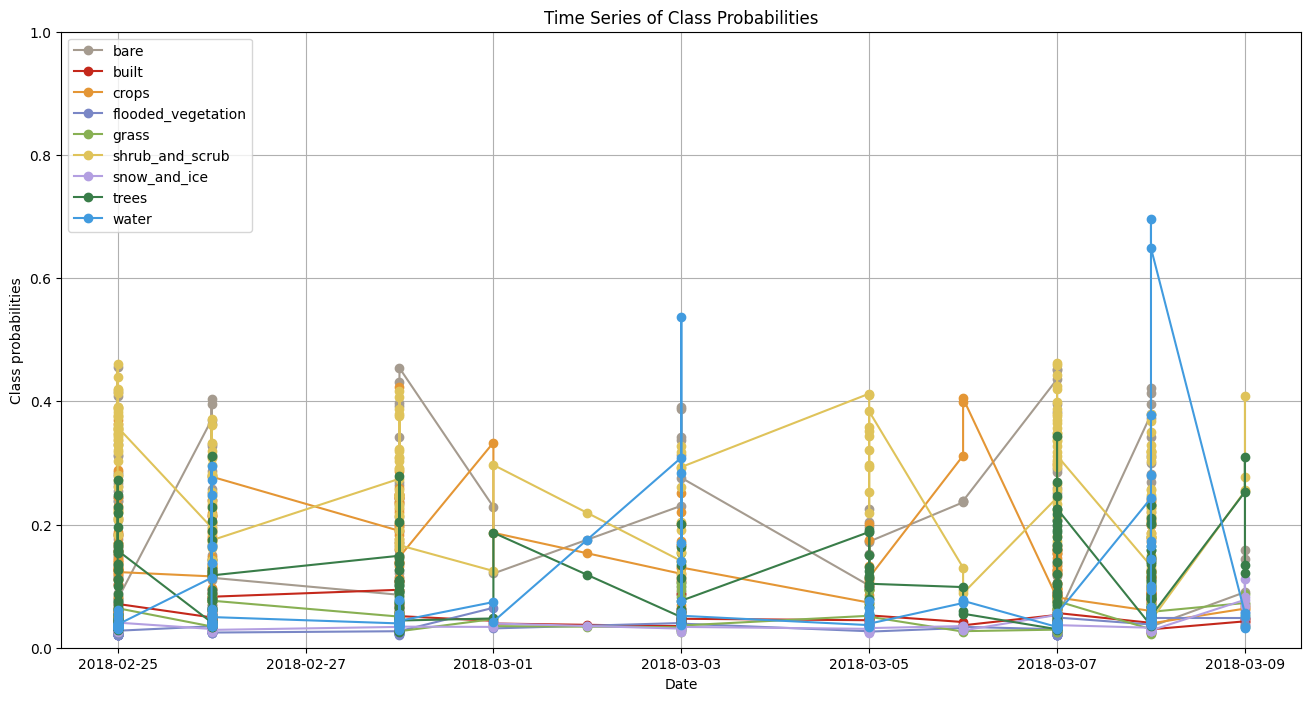

In [ ]:
# Define the band names and their colors.
bands = ['bare', 'built', 'crops', 'flooded_vegetation', 'grass', 'shrub_and_scrub', 'snow_and_ice', 'trees', 'water']
colors = ['#A59B8F', '#C4281B', '#E49635', '#7A87C6', '#88B053', '#DFC35A', '#B39FE1', '#397D49', '#419BDF']

# Extract the time series data.
def extract_time_series(image):
    mean_values = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=10,
        bestEffort = True
    )
    return ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'),
        **{band: mean_values.get(band) for band in bands}
    })

time_series = dw_time_series.map(extract_time_series).getInfo()

# Convert the extracted data to a DataFrame.
data = []
for feature in time_series['features']:
    properties = feature['properties']
    row = {'date': properties.pop('date')}
    row.update({band: properties.get(band) for band in bands})
    data.append(row)

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Interpolate missing values to ensure continuous lines.
df_interpolated = df.interpolate(method='linear')

# Plot the time series.
plt.figure(figsize=(16, 8))
for i, band in enumerate(bands):
    plt.plot(df_interpolated['date'], df_interpolated[band], label=band, color=colors[i], marker='o', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Class probabilities')
plt.title('Time Series of Class Probabilities')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

### Change Detection using probability band

In [ ]:
Map = geemap.Map()

Map.centerObject(geometry, 12)

In [ ]:
BEFORE = 2018
AFTER = 2018

B_START = ee.Date.fromYMD(BEFORE, 1, 1)
B_END = B_START.advance(1, 'year')

A_START = ee.Date.fromYMD(AFTER, 1, 1)
A_END = A_START.advance(1, 'year')

In [ ]:
# Setting specific dates as strings
BEFORE = '2018-01-01'
B_END = '2018-02-25'
AFTER = '2018-03-10'
A_END = '2018-04-30'

# Parsing the strings into ee.Date objects
B_START = ee.Date.parse('YYYY-MM-DD', BEFORE)
B_END = ee.Date.parse('YYYY-MM-DD', B_END)

A_START = ee.Date.parse('YYYY-MM-DD', AFTER)
A_END = ee.Date.parse('YYYY-MM-DD', A_END)

In [ ]:
dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
      .filterBounds(geometry)
      .select('built'))

BEFORE_dw = dw.filterDate(B_START, B_END).mean()
AFTER_dw = dw.filterDate(A_START, A_END).mean()

In [ ]:
# select all pixels that are
#       < 0.2 'built' probability before
#       > 0.5 'built probability after
new_urban = BEFORE_dw.lt(0.2).And(AFTER_dw.gt(0.5))

change_vis_params = {
    'min': 0,
    'max':1,
    'palette': ['white', 'red']
}

Map.add_layer(new_urban.clip(geometry), change_vis_params, "New Urban")

In [ ]:
# Red pixels Indicating Detected Urban Sprawl between 2019 and 2020
Map

Map(center=[0.533632646340545, 37.860264927953864], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
collections.first()

In [ ]:
# Function to generate a list of dates
def generate_date_list(start_date, end_date):
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return date_list

# Generate a list of dates for the year 2018
date = generate_date_list(datetime(2018, 1, 1), datetime(2018, 12, 31))

test = collections.filter(ee.Filter.inList('date', date))

In [ ]:
# Setting specific dates as strings
BEFORE = '2017-01-01'
B_END = '2018-02-25'
AFTER = '2018-03-10'
A_END = '2018-04-30'

# Parsing the strings into ee.Date objects
B_START = ee.Date.parse('YYYY-MM-DD', BEFORE)
B_END = ee.Date.parse('YYYY-MM-DD', B_END)

A_START = ee.Date.parse('YYYY-MM-DD', AFTER)
A_END = ee.Date.parse('YYYY-MM-DD', A_END)

s2 = (ee.ImageCollection('COPERNICUS/S2')
    .filterBounds(geometry)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35)))

BEFORE_S2 = s2.filterDate(B_START, B_END).median()
AFTER_S2 = s2.filterDate(A_START, A_END).median()

s2_vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000
}

# FUnction
def change_detection_using_prob_band(class_name, color) -> geemap.Map:
    dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
          .filterBounds(geometry)
          .select(class_name))

    BEFORE_dw = dw.filterDate(B_START, B_END).mean()
    AFTER_dw = dw.filterDate(A_START, A_END).mean()

    # select all pixels that are
    #       < 0.2 'built' probability before
    #       > 0.5 'built probability after
    new_area = BEFORE_dw.lt(0.2).And(AFTER_dw.gt(0.5))

    # Calculate the pixels
    pixel_area = ee.Image.pixelArea()
    new_area_pixels = new_area.multiply(pixel_area)
    total_area = new_area_pixels.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=10,
        maxPixels=1e9,
        bestEffort = True
    )

    total_area_result = total_area.getInfo()
    print(f"Total area of new {class_name} regions: {list(total_area_result.items())[0][1] / 1e6:.3f} square km")

    change_vis_params = {
        'min': 0,
        'max':1,
        'palette': ['white', color]
    }

    Map.centerObject(geometry, 12)
    Map.add_layer(BEFORE_S2.clip(geometry), s2_vis_params, 'Before S2')
    Map.add_layer(AFTER_S2.clip(geometry), s2_vis_params, 'After S2')
    Map.add_layer(new_area.selfMask().clip(geometry), change_vis_params, "New Urban")
    Map.add_layer(new_area.clip(geometry), change_vis_params, "New Urban")

    return Map

Map = geemap.Map()
Map.addLayerControl()
change_detection_using_prob_band('built', 'red')

In [ ]:
coordinates = test.first().geometry().coordinates().getInfo()

In [ ]:
# Function to convert milliseconds since epoch to a human-readable date
def ms_to_date(ms):
    return datetime.utcfromtimestamp(ms / 1000).strftime('%Y-%m-%d')

In [ ]:
country_name = "Madagascar"
africa_shapefile = ee.FeatureCollection(asset_PATH)
geometry = africa_shapefile.filter(ee.Filter.eq('ADM0_NAME', country_name))

# Setting specific dates as strings
BEFORE = '2018-03-01'
B_END = '2018-04-25'
AFTER = '2018-05-10'
A_END = '2018-07-01'

# Parsing the strings into ee.Date objects
B_START = ms_to_date(ee.Date(BEFORE).getInfo()['value'])
B_END = ms_to_date(ee.Date(B_END).getInfo()['value'])

A_START = ms_to_date(ee.Date(AFTER).getInfo()['value'])
A_END = ms_to_date(ee.Date(A_END).getInfo()['value'])

# Coordinates of the disaster
disaster_coords = ee.Geometry.Point([coordinates[0], coordinates[1]])  # replace with actual longitude and latitude
buffer_distance = 20000  # buffer distance in meters

# Create a buffer around the disaster coordinates
geometry = disaster_coords.buffer(buffer_distance)

s2 = (ee.ImageCollection('COPERNICUS/S2')
    .filterBounds(geometry)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35)))

BEFORE_S2 = s2.filterDate(B_START, B_END).median()
AFTER_S2 = s2.filterDate(A_START, A_END).median()

s2_vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000
}

# Function
def change_detection_using_prob_band(class_name, color) -> geemap.Map:
    dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
          .filterBounds(geometry)
          .select(class_name))

    BEFORE_dw = dw.filterDate(B_START, B_END).mean()
    AFTER_dw = dw.filterDate(A_START, A_END).mean()

    # select all pixels that are
    #       < 0.2 'built' probability before
    #       > 0.5 'built probability after
    new_area = BEFORE_dw.lt(0.2).And(AFTER_dw.gt(0.5))

    # Calculate the pixels
    pixel_area = ee.Image.pixelArea()
    new_area_pixels = new_area.multiply(pixel_area)
    total_area = new_area_pixels.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=10,
        maxPixels=1e9,
        bestEffort=True
    )

    total_area_result = total_area.getInfo()
    print(f"Total area of new {class_name} regions: {list(total_area_result.items())[0][1] / 1e6:.3f} square km")

    change_vis_params = {
        'min': 0,
        'max': 1,
        'palette': ['white', color]
    }

    Map.centerObject(geometry, 12)
    Map.add_layer(BEFORE_S2.clip(geometry), s2_vis_params, 'Before S2')
    Map.add_layer(AFTER_S2.clip(geometry), s2_vis_params, 'After S2')
    Map.add_layer(new_area.selfMask().clip(geometry), change_vis_params, "New Urban")
    Map.add_layer(new_area.clip(geometry), change_vis_params, "New Urban")
    Map.addLayerControl()

    return Map

Map = geemap.Map()
change_detection_using_prob_band('built', 'red')
Map

Total area of new built regions: 0.003 square km


Map(center=[-20.032134142354405, 48.5170036556215], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# bands: 0: "water", 1: "trees", 2: "grass", 3: "flooded_vegetation", 4: "crops", 5: "shrub_and_scrub", 6: "built", 7: "bare", 8: "snow_and_ice"
Map = geemap.Map()
Map.addLayerControl()
change_detection_using_prob_band('trees', 'green')
Map

Total area of new trees regions: 2.519 square km


Map(center=[-20.032134142354405, 48.5170036556215], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# bands: 0: "water", 1: "trees", 2: "grass", 3: "flooded_vegetation", 4: "crops", 5: "shrub_and_scrub", 6: "built", 7: "bare", 8: "snow_and_ice"

Map = geemap.Map()
Map.addLayerControl()
change_detection_using_prob_band('crops', 'yellow')
Map

Total area of new crops regions: 0.000 square km


Map(center=[-20.032134142354405, 48.5170036556215], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# bands: 0: "water", 1: "trees", 2: "grass", 3: "flooded_vegetation", 4: "crops", 5: "shrub_and_scrub", 6: "built", 7: "bare", 8: "snow_and_ice"

Map = geemap.Map()
Map.addLayerControl()
change_detection_using_prob_band('water', 'blue')
Map

Total area of new water regions: 0.000 square km


Map(center=[-20.032134142354405, 48.5170036556215], controls=(WidgetControl(options=['position', 'transparent_…

## Change detection for every class and combine them in one map (to use later)

In [ ]:
country_name = "Madagascar"
africa_shapefile = ee.FeatureCollection(asset_PATH)
geometry = africa_shapefile.filter(ee.Filter.eq('ADM0_NAME', country_name))

# Setting specific dates as strings
BEFORE = '2018-03-01'
B_END = '2018-04-25'
AFTER = '2018-05-10'
A_END = '2018-07-01'

# Parsing the strings into ee.Date objects
B_START = ms_to_date(ee.Date(BEFORE).getInfo()['value'])
B_END = ms_to_date(ee.Date(B_END).getInfo()['value'])

A_START = ms_to_date(ee.Date(AFTER).getInfo()['value'])
A_END = ms_to_date(ee.Date(A_END).getInfo()['value'])

# Coordinates of the disaster
coordinates = test.first().geometry().coordinates().getInfo()  # replace with actual longitude and latitude
disaster_coords = ee.Geometry.Point([coordinates[0], coordinates[1]])
buffer_distance = 25000  # buffer distance in meters

# Create a buffer around the disaster coordinates
geometry = disaster_coords.buffer(buffer_distance)

s2 = (ee.ImageCollection('COPERNICUS/S2')
    .filterBounds(geometry)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35)))

BEFORE_S2 = s2.filterDate(B_START, B_END).median()
AFTER_S2 = s2.filterDate(A_START, A_END).median()

s2_vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000
}

classes_colors = {
    'water': '#419bdf',
    'trees': '#397d49',
    'grass': '#88b053',
    'flooded_vegetation': '#7a87c6',
    'crops': '#e59635',
    'shrub_and_scrub': '#dfc35a',
    'built': '#c4281b',
    'bare': '#a59b8f',
    'snow_and_ice': '#b39fe1'
}

# Function
def change_detection_all_classes(classes_colors) -> geemap.Map:
    Map = geemap.Map()
    Map.centerObject(geometry, 12)
    Map.add_layer(BEFORE_S2.clip(geometry), s2_vis_params, 'Before S2')
    Map.add_layer(AFTER_S2.clip(geometry), s2_vis_params, 'After S2')

    for class_name, color in classes_colors.items():
        dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
              .filterBounds(geometry)
              .select(class_name))

        BEFORE_dw = dw.filterDate(B_START, B_END).mean()
        AFTER_dw = dw.filterDate(A_START, A_END).mean()

        # select all pixels that are
        #       < 0.2 class probability before
        #       > 0.5 class probability after
        new_area = BEFORE_dw.lt(0.2).And(AFTER_dw.gt(0.5))

        # Calculate the pixels
        pixel_area = ee.Image.pixelArea()
        new_area_pixels = new_area.multiply(pixel_area)
        total_area = new_area_pixels.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geometry,
            scale=10,
            maxPixels=1e9,
            bestEffort=True
        )

        total_area_result = total_area.getInfo()
        print(f"Total area of new {class_name} regions: {list(total_area_result.items())[0][1] / 1e6:.3f} square km")

        change_vis_params = {
            'min': 0,
            'max': 1,
            'palette': ['white', color]
        }

        built_vis_params = {
            'min': 0,
            'max': 1,
            'palette': ['blue']
        }

        Map.add_layer(new_area.selfMask().clip(geometry), change_vis_params, f"New {class_name.capitalize()}")
        Map.add_layer(new_area.clip(geometry), change_vis_params, f"New {class_name.capitalize()}")
        Map.add_layer(BEFORE_dw.clip(geometry).selfMask(), built_vis_params, f'{class_name.capitalize()} Before')
        Map.add_layer(AFTER_dw.clip(geometry).selfMask(), built_vis_params, f'{class_name.capitalize()} After')

    Map.addLayerControl()
    return Map

# Call the function
Map = change_detection_all_classes(classes_colors)
Map

Total area of new water regions: 0.000 square km
Total area of new trees regions: 5.037 square km
Total area of new grass regions: 0.017 square km
Total area of new flooded_vegetation regions: 0.010 square km
Total area of new crops regions: 0.000 square km
Total area of new shrub_and_scrub regions: 0.157 square km
Total area of new built regions: 0.006 square km
Total area of new bare regions: 0.115 square km
Total area of new snow_and_ice regions: 0.000 square km


Map(center=[-20.032129013037725, 48.517003807024395], controls=(WidgetControl(options=['position', 'transparen…

#### Decision tree

In [ ]:
# Define decision tree rules.
# Rule 1: Built probability < 0.2 before and > 0.5 after
rule1 = BEFORE_dw.lt(0.2).And(AFTER_dw.gt(0.5))

# Rule 2: Built probability < 0.1 before and > 0.4 after
rule2 = BEFORE_dw.lt(0.1).And(AFTER_dw.gt(0.4))

# Combine rules using logical OR.
new_urban_dt = rule1.Or(rule2)

Map = geemap.Map()

# Visualize the change.
change_vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'red']
}
Map.addLayer(new_urban_dt.selfMask().clip(geometry), change_vis_params, "New Urban Areas")

# Display the map.
Map.centerObject(geometry, 12)
Map

Map(center=[12.942208526432214, 77.5868323785926], controls=(WidgetControl(options=['position', 'transparent_b…

## Nigeria

In [ ]:
df = pd.read_excel("/content/CERI/data/processed/Disasters_in_africa_2000_2018_processed.xlsx")
df

disasterno     Country         Location Disaster type  Year       Date  \
0    1999-9388       Sudan  Northern Darfur       Drought  2000 2000-01-01   
1    1999-9388     Somalia       Ceel Barde       Drought  2000 2000-01-01   
2    2000-0012  Mozambique        Matutuine         Flood  2000 2000-01-26   
3    2000-0012  Mozambique          Manhica         Flood  2000 2000-01-26   
4    2000-0012  Mozambique           Magude         Flood  2000 2000-01-26   
..         ...         ...              ...           ...   ...        ...   
983  2018-0162     Algeria           Tiaret         Flood  2018 2018-04-24   
984  2018-0232       Niger           Maradi         Flood  2018 2018-06-01   
985  2018-0292       Sudan    West Kordofan         Flood  2018 2018-07-23   
986  2018-0365     Nigeria             Kogi         Flood  2018 2018-09-20   
987  2018-0387       Sudan          Kassala         Flood  2018 2018-08-01   

     Total deaths   Latitude  Longitude  
0               0  12.345280  23.438724  
1              21   4.663144  43.991431  
2             800 -26.524360  32.561550  
3             800 -25.308950  32.825503  
4             800 -24.701850  32.439407  
..            ...        ...        ...  
983             6  34.965109   1.530424  
984            36  14.116153   7.299178  
985            23  11.761982  28.405309  
986           199   7.716356   6.696042  
987            23  15.988691  35.750775  

[988 rows x 9 columns]

In [ ]:
# Group by Country and Date and aggregate Location into lists
grouped_df = df.groupby(['Country', 'Date']).agg({
    'disasterno': 'first',
    'Location': lambda x: list(x),
    'Disaster type': 'first',
    'Year': 'first',
    'Total deaths': 'sum',
    'Latitude': lambda x: list(x),
    'Longitude': lambda x: list(x)
}).reset_index()

# Print the resulting DataFrame
grouped_df.to_excel("/content/CERI/data/processed/Disasters_in_africa_2000_2018_processed_new.xlsx")

In [ ]:
collections = feature2ee("/content/CERI/data/processed/Disasters_in_africa_2000_2018_processed_new.xlsx")

An error occurred: Invalid geometry.


In [ ]:
collections

In [ ]:
collections.filter(ee.Filter.eq("country", "Kenya"))

In [ ]:
filtered_collection

In [ ]:
Disaster_date = '2018-03-03'
area_affected = collections.filter(ee.Filter.eq('date', Disaster_date))

In [ ]:
area_affected

In [ ]:
grouped_df

Country       Date disasterno  \
0     Algeria 2001-11-10  2001-0620   
1     Algeria 2002-08-17  2002-0540   
2     Algeria 2002-10-09  2002-0648   
3     Algeria 2003-01-31  2003-0059   
4     Algeria 2003-04-02  2003-0160   
..        ...        ...        ...   
399  Zimbabwe 2010-05-01  2010-9181   
400  Zimbabwe 2013-01-01  2013-9478   
401  Zimbabwe 2014-01-20  2014-0066   
402  Zimbabwe 2014-12-01  2014-0514   
403  Zimbabwe 2016-12-09  2016-0523   

                                              Location Disaster type  Year  \
0    [Ain Benian, Bouzareah, El Marsa, Moussadek, T...         Flood  2001   
1                   [Oum El Bouaghi, Khenchela, Medea]         Flood  2002   
2                                              [Batna]         Flood  2002   
3                  [Alger, Bejaia, Tizi Ouzou, Annaba]         Storm  2003   
4             [Tizi Ouzou, Annaba, Blida, Constantine]         Flood  2003   
..                                                 ...           ...   ...   
399                                       [Manicaland]       Drought  2010   
400                                       [Manicaland]       Drought  2013   
401                                [Chivi, Tsholotsho]         Flood  2014   
402                                       [Manicaland]         Flood  2014   
403                                           [Mangwe]         Storm  2016   

     Total deaths                                           Latitude  \
0           30393  [36.35101602, 36.78232484, 36.40397212, 36.349...   
1              87            [35.83530914, 34.98236823, 35.97846063]   
2              13                                      [35.41962414]   
3              52  [36.707393, 36.57848435, 36.67457384, 36.83847...   
4              60  [36.67457384, 36.83847484, 36.49210826, 36.347...   
..            ...                                                ...   
399             0                                     [-19.06116231]   
400             0                                     [-19.06116231]   
401             6                        [-20.4938609, -19.61801311]   
402            11                                     [-19.06116231]   
403            31                                     [-20.97603803]   

                                             Longitude  
0    [2.37817825, 3.021624121, 0.95661681, 1.028662...  
1              [7.066078632, 6.996738835, 2.922806182]  
2                                        [5.874301764]  
3    [3.056515494, 4.838826693, 4.203980628, 7.5428...  
4    [4.203980628, 7.542842368, 2.920971089, 6.6880...  
..                                                 ...  
399                                      [32.39751357]  
400                                      [32.39751357]  
401                         [30.57852573, 27.41828561]  
402                                      [32.39751357]  
403                                      [28.00825613]  

[404 rows x 9 columns]

In [ ]:
# Filter the DataFrame for the specific country and date
country_name = "Kenya"
disaster_date = '2018-03-14'
filtered_df = df[(df['Country'] == country_name) & (df['Date'] == disaster_date)]

In [ ]:
# Iterate over the filtered DataFrame and perform change detection for each location
for index, row in filtered_df.iterrows():
    print(row['Latitude'], row['Longitude'])

-1.290546381 36.86666878
-1.524777551 39.41762555


In [ ]:
coordinates = area_affected.first().geometry().coordinates().getInfo()

In [ ]:
# Define the function to convert milliseconds to ee.Date
def ms_to_date(ms):
    return ee.Date(ms)

# Filter the DataFrame for the specific country and date
country_name = "Kenya"
disaster_date = '2018-03-14'
filtered_df = df[(df['Country'] == country_name) & (df['Date'] == disaster_date)]

# Define the time ranges for before and after the disaster
BEFORE = '2018-01-01'
B_END = '2018-03-12'
AFTER = '2018-03-16'
A_END = '2018-05-29'

# Convert the dates to ee.Date objects
B_START = ms_to_date(ee.Date(BEFORE).getInfo()['value'])
B_END = ms_to_date(ee.Date(B_END).getInfo()['value'])
A_START = ms_to_date(ee.Date(AFTER).getInfo()['value'])
A_END = ms_to_date(ee.Date(A_END).getInfo()['value'])

# Define visualization parameters
s2_vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000
}

classes_colors = {
    'water': '#419bdf',
    'trees': '#397d49',
    'grass': '#88b053',
    'flooded_vegetation': '#7a87c6',
    'crops': '#e59635',
    'shrub_and_scrub': '#dfc35a',
    'built': '#c4281b',
    'bare': '#a59b8f',
    'snow_and_ice': '#b39fe1'
}

# Initialize the map
Map = geemap.Map()

# Function to perform change detection for each location
def change_detection_for_location(lat, lon):
    disaster_coords = ee.Geometry.Point([lon, lat])
    buffer_distance = 2000  # buffer distance in meters
    geometry = disaster_coords.buffer(buffer_distance)

    s2 = (ee.ImageCollection('COPERNICUS/S2')
        .filterBounds(geometry)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35)))

    BEFORE_S2 = s2.filterDate(B_START, B_END).median()
    AFTER_S2 = s2.filterDate(A_START, A_END).median()

    Map.centerObject(geometry, 12)
    Map.add_layer(BEFORE_S2.clip(geometry), s2_vis_params, 'Before S2')
    Map.add_layer(AFTER_S2.clip(geometry), s2_vis_params, 'After S2')

    for class_name, color in classes_colors.items():
        dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
              .filterBounds(geometry)
              .select(class_name))

        BEFORE_dw = dw.filterDate(B_START, B_END).mean()
        AFTER_dw = dw.filterDate(A_START, A_END).mean()

        # Select all pixels that are
        #       < 0.2 class probability before
        #       > 0.5 class probability after
        new_area = BEFORE_dw.lt(0.2).And(AFTER_dw.gt(0.5))

        # Calculate the pixels
        pixel_area = ee.Image.pixelArea()
        new_area_pixels = new_area.multiply(pixel_area)
        total_area = new_area_pixels.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geometry,
            scale=10,
            maxPixels=1e9,
            bestEffort=True
        )

        total_area_result = total_area.getInfo()
        print(f"Total area of new {class_name} regions at ({lat}, {lon}): {list(total_area_result.items())[0][1] / 1e6:.3f} square km")

        change_vis_params = {
            'min': 0,
            'max': 1,
            'palette': ['white', color]
        }

        Map.add_layer(new_area.selfMask().clip(geometry), change_vis_params, f"New {class_name.capitalize()} at ({lat}, {lon})")
        Map.add_layer(new_area.clip(geometry), change_vis_params, f"New {class_name.capitalize()} at ({lat}, {lon})")
        Map.add_layer(BEFORE_dw.clip(geometry).selfMask(), {'min': 0, 'max': 1, 'palette': ['blue']}, f'{class_name.capitalize()} Before at ({lat}, {lon})')
        Map.add_layer(AFTER_dw.clip(geometry).selfMask(), {'min': 0, 'max': 1, 'palette': ['blue']}, f'{class_name.capitalize()} After at ({lat}, {lon})')

# Iterate over the filtered DataFrame and perform change detection for each location
for index, row in filtered_df.iterrows():
    change_detection_for_location(row['Latitude'], row['Longitude'])

# Display the map
Map.addLayerControl()
Map

Total area of new water regions at (-1.290546381, 36.86666878): 0.000 square km
Total area of new trees regions at (-1.290546381, 36.86666878): 0.189 square km
Total area of new grass regions at (-1.290546381, 36.86666878): 0.003 square km
Total area of new flooded_vegetation regions at (-1.290546381, 36.86666878): 0.000 square km


In [ ]:
# Function to export data to GeoTIFF
def export_to_geotiff(image, geometry, description):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder='GEE_exports',  # Specify your Google Drive folder
        fileNamePrefix=description,
        region=geometry,
        scale=10,
        maxPixels=1e9
    )
    task.start()

# Export the new_area to GeoTIFF
description = f'New_{class_name}_at_{lat}_{lon}'
export_to_geotiff(new_area.selfMask(), geometry, description)

### Validate the change

In [ ]:
s2 = (ee.ImageCollection('COPERNICUS/S2')
    .filterBounds(geometry)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35)))

BEFORE_S2 = s2.filterDate(B_START, B_END).median()
AFTER_S2 = s2.filterDate(A_START, A_END).median()

s2_vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000
}

# Visualize the change.
change_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['white', 'red']
}

S2_map = geemap.Map()
S2_map.add_layer(BEFORE_S2.clip(geometry), s2_vis_params, 'Before S2')
S2_map.add_layer(AFTER_S2.clip(geometry), s2_vis_params, 'After S2')
S2_map.add_layer(new_urban_area.selfMask().clip(geometry), change_vis_params, "new urban (masked)")

S2_map.centerObject(geometry, 12)
S2_map

Map(center=[12.942208526432214, 77.5868323785926], controls=(WidgetControl(options=['position', 'transparent_b…

# Change Detection

In [ ]:
# Define the color palette and class values
color_palette = [
    '#ffff64', '#ffff64', '#ffff00', '#aaf0f0', '#dcf064', '#c8c864', '#006400',
    '#00a000', '#00a000', '#aac800', '#003c00', '#003c00', '#005000', '#285000',
    '#285000', '#286400', '#788200', '#8ca000', '#be9600', '#966400', '#966400',
    '#966400', '#ffb432', '#ffdcd2', '#ffebaf', '#ffc864', '#ffd278', '#ffebaf',
    '#00785a', '#009678', '#00dc82', '#c31400', '#fff5d7', '#dcdcdc', '#fff5d7',
    '#0046c8', '#ffffff'
]

class_values = [
    10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90,
    100, 110, 120, 121, 122, 130, 140, 150, 151, 152, 153, 160, 170, 180, 190,
    200, 201, 202, 210, 220
]

class_names = [
    "Cropland rainfed", "Cropland irrigated or post-flooding", "Mosaic cropland (>50%) / natural vegetation (<50%)",
    "Mosaic natural vegetation (>50%) / cropland (<50%)", "Tree cover broadleaved evergreen (>15%)",
    "Tree cover broadleaved deciduous (>15%)", "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved deciduous (>15%)", "Tree cover mixed leaf type (broadleaved and needleleaved)",
    "Mosaic tree and shrub (>50%) / herbaceous cover (<50%)", "Mosaic herbaceous cover (>50%) / tree and shrub (<50%)",
    "Shrubland", "Grassland", "Lichens and mosses", "Sparse vegetation (<15%)", "Tree cover flooded fresh/brackish water",
    "Tree cover flooded saline water", "Shrub or herbaceous cover flooded", "Urban areas", "Bare areas",
    "Water bodies", "Permanent snow and ice", "Tree cover (>50%)", "Herbaceous cover (>50%)", "Snow and ice",
    "Water bodies", "Bare areas", "Urban areas", "Tree cover flooded", "Shrub cover flooded",
    "Herbaceous cover flooded", "Tree cover flooded", "Snow and ice", "Bare areas", "Permanent snow and ice",
    "Urban areas", "Water bodies"
]

# Ensure the number of colors matches the number of class values
assert len(color_palette) == len(class_values), "The number of colors must match the number of class values"
assert len(class_names) == len(class_values), "The number of class names must match the number of class values"

# Path to your TIFF file
tiff_file_path = '/content/drive/MyDrive/Project files/clipped_rasters/2001/Djibouti_LULC_2000_lccs_class_the_year_before_disaster.tif'  # Replace with your actual path

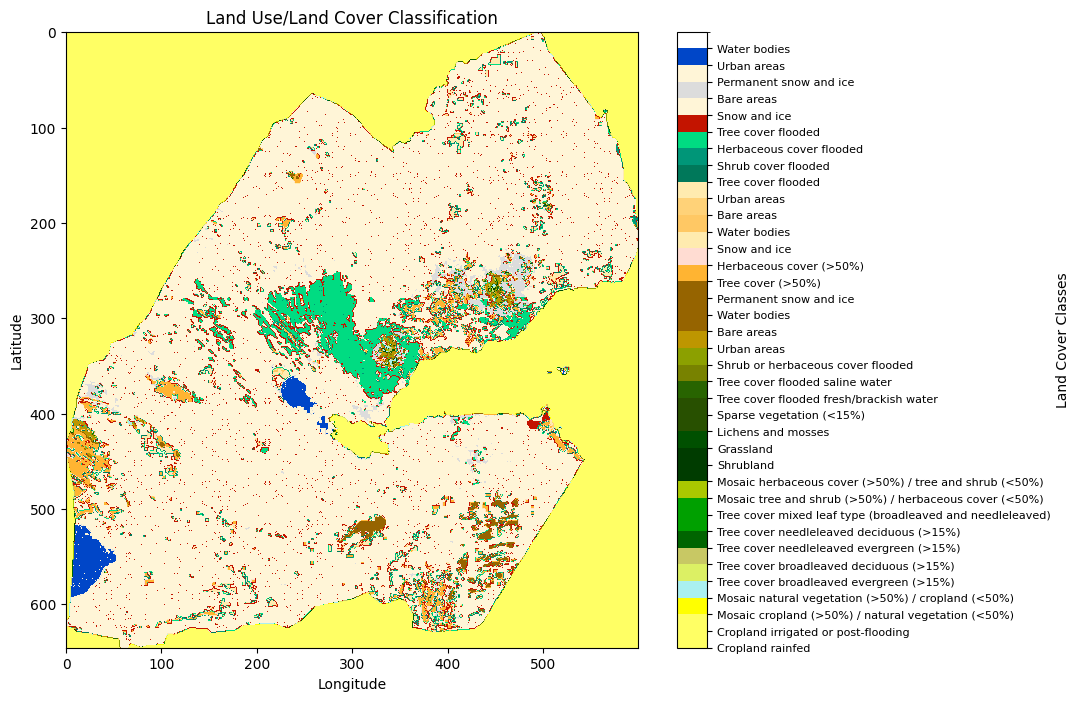

In [ ]:
# Open the TIFF file using rasterio
with rasterio.open(tiff_file_path) as src:
    # Read the entire dataset
    data = src.read(1)  # Reading only the first band, adjust if needed

    # Get the metadata
    profile = src.profile

    # Get the coordinates
    transform = src.transform
    x_coords = np.arange(profile['width']) * transform[0] + transform[2]
    y_coords = np.arange(profile['height']) * transform[4] + transform[5]

# Create a DataArray from the raster data
da = xr.DataArray(
    data,
    dims=("y", "x"),
    coords={
        "y": y_coords,
        "x": x_coords,
    },
    attrs=profile,
)

# Convert the DataArray to a Dataset
ds = xr.Dataset({"raster": da})

# Create a custom colormap
cmap = ListedColormap(color_palette)
norm = BoundaryNorm(class_values + [class_values[-1] + 1], cmap.N)

# Plotting the raster data with the custom colormap
plt.figure(figsize=(10, 8))
im = plt.imshow(ds.raster, cmap=cmap, norm=norm)

# Create a colorbar with custom tick labels
cbar = plt.colorbar(im, boundaries=class_values + [class_values[-1] + 1], ticks=class_values)
cbar.ax.set_yticklabels(class_names, fontsize=8)
cbar.ax.set_ylabel('Land Cover Classes')

plt.title('Land Use/Land Cover Classification')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Copernicus Climate Change Service, Climate Data Store, (2019): Land cover classification gridded maps from 1992 to present derived from satellite observation. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.006f2c9a (Accessed on DD-MMM-YYYY)

# Land cover classification

In [ ]:
!wget 'http://madm.dfki.de/files/sentinel/EuroSATallBands.zip'

--2024-05-19 12:25:52--  http://madm.dfki.de/files/sentinel/EuroSATallBands.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2067725275 (1.9G) [application/zip]
Saving to: ‘EuroSATallBands.zip’

EuroSATallBands.zip 100%[===================>]   1.92G  20.9MB/s    in 93s     

2024-05-19 12:27:25 (21.2 MB/s) - ‘EuroSATallBands.zip’ saved [2067725275/2067725275]



In [ ]:
!unzip 'EuroSATallBands.zip'

In [ ]:
REMOTE_SENSING_DATA_PATH = 'ds/images/remote_sensing/otherDatasets/sentinel_2/tif'

In [ ]:
!pip install -U torchsat

In [ ]:
import os
import tifffile as tiff
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import torch
from PIL import Image

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        for label in os.listdir(self.data_dir):
            class_dir = os.path.join(self.data_dir, label)
            if os.path.isdir(class_dir):
                for img_file in os.listdir(class_dir):
                    self.image_paths.append(os.path.join(class_dir, img_file))
                    self.labels.append(label)
        # Print the number of images and labels loaded
        print(f"Loaded {len(self.image_paths)} images with {len(self.labels)} labels.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = tiff.imread(img_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        # Print the image path and label for the current index
        print(f"Loading image: {img_path}, Label: {label}")
        return image, label

# Usage
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

data_dir = '/content/ds/images/remote_sensing/otherDatasets/sentinel_2/tif'  # Replace with your actual data path
dataset = CustomDataset(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Loaded 27000 images with 27000 labels.


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio

class RemoteSensingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for label, class_dir in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_dir)
            for img_name in os.listdir(class_path):
                if img_name.endswith('.tiff') or img_name.endswith('.tif'):
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open the image using rasterio
        with rasterio.open(img_path) as src:
            img = src.read()

        # Convert the image to a PIL image
        img = Image.fromarray(img.transpose(1, 2, 0))  # rasterio reads as (channels, height, width)

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = RemoteSensingDataset(root_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(dataloader)

844

In [ ]:
img, label = next(iter(dataloader))

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define a simple model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 128 * 128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

num_classes = len(os.listdir(data_dir))
model = SimpleCNN(num_classes=num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in dataloader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')